# Imports



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer

from imblearn.over_sampling import SMOTE

from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
import torch

import nltk
import umap

from sklearn.preprocessing import MinMaxScaler
from umap import UMAP


# Download the dataset

In [4]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'medicaltranscriptions:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F64826%2F127612%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240831%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240831T182720Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4a27ad755a3596b29cde11a9c1eb657c8cc587f3830d1cb4f3e4e3ba21ab9cda0d12b3282935ac6903f6414c51da8c7ee4dee1bb5b30569590a03024ff2380237d1edae72e8a24532c13913695e4b429ef6837dae1575ef8ead9c30de2750f779a4404fec7efdf79c6d36f6220f56df135a7be4fd4d642e508c25b13d0f0123d18b4f5d1d9925b64c4bfe702012dfc50b45deac9cfae976e72de90301365b2d01759b807ee123be46194bc7de766640accf08219dffa232a2ef6428b33744231b4d4954e9f41b87ee7935d9497cefe9ac9bd3a77a6eed1ed253ce6f44f041bb773897cccc6245093dc4c1049009e7463b94e91625a8643f79572b07590a229b5'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 5083317 bytes downloaded
Downloaded and uncompressed: medicaltranscriptions
Data source import complete.


# Dataframe analysis

In [5]:
clinical_text_dataframe = pd.read_csv("/kaggle/input/medicaltranscriptions/mtsamples.csv")
print(clinical_text_dataframe.columns)
clinical_text_dataframe.head(5)

Index(['Unnamed: 0', 'description', 'medical_specialty', 'sample_name',
       'transcription', 'keywords'],
      dtype='object')


,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


Index(['Unnamed: 0', 'description', 'medical_specialty', 'sample_name',
       'transcription', 'keywords'],
      dtype='object')


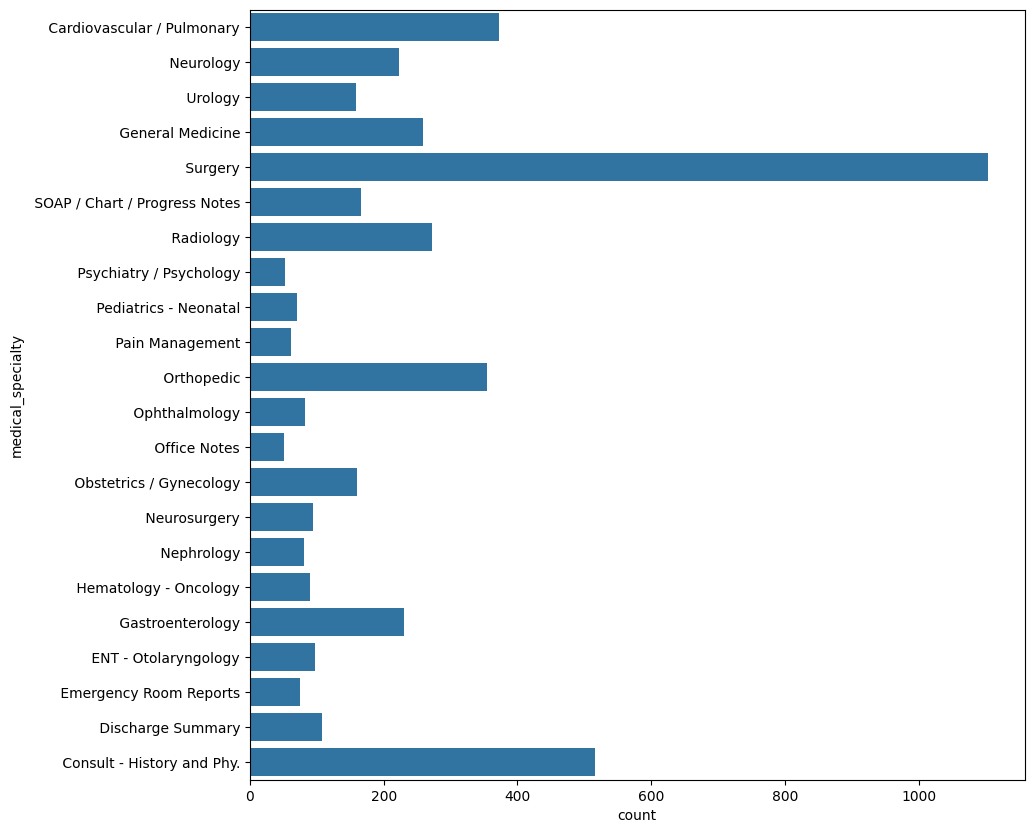

In [6]:
clinical_text_dataframe = pd.read_csv("/kaggle/input/medicaltranscriptions/mtsamples.csv")
print(clinical_text_dataframe.columns)
clinical_text_dataframe.head(5)

medical_speciality_categories = clinical_text_dataframe.groupby(clinical_text_dataframe['medical_specialty'])

filtered_data_categories = medical_speciality_categories.filter(lambda x:x.shape[0] > 50)
final_data_categories = filtered_data_categories.groupby(filtered_data_categories['medical_specialty'])

plt.figure(figsize=(10,10))
sns.countplot(y='medical_specialty', data = filtered_data_categories )
plt.show()


##a) Definição e apresentação da estrutura e divisão do dataset para treinamento, validação e teste.

A partir da base de dados de textos clínicos foram pegos 6 especialidades médicas junto com as transcrições. Desse conjunto de dados foram feita a divisão do dataset para o treinamento, validação e testa da seguinte forma:


<ipython-input-7-69c6c27ad1ad>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Medical Specialty', y='Count', data=class_distribution, palette='viridis')


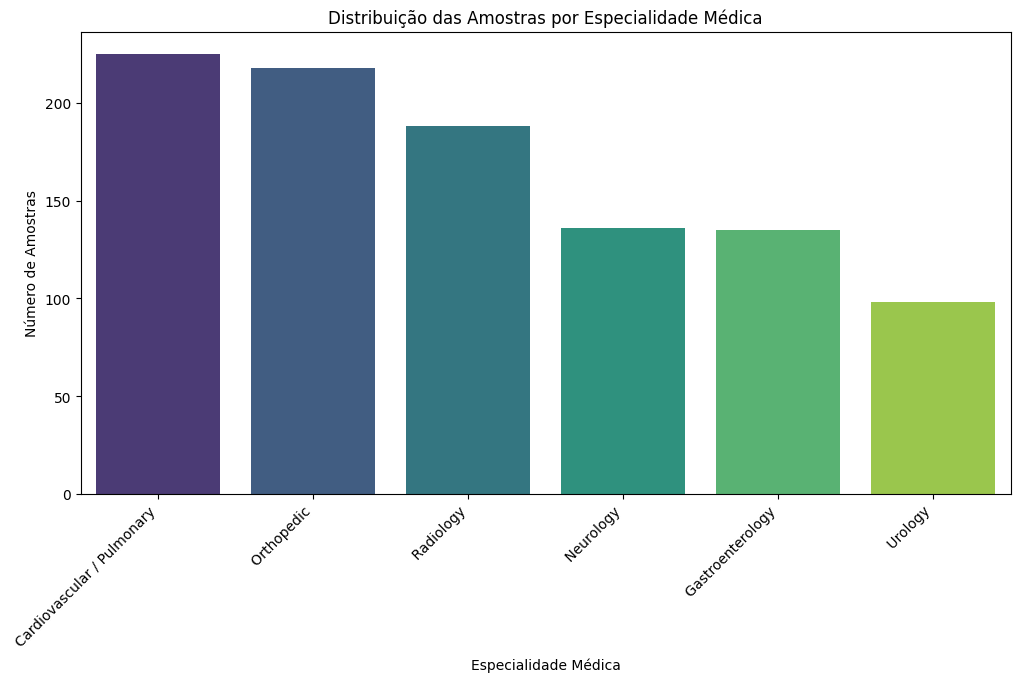

In [7]:
# Selecionando as colunas de interesse
clinical_selected_text = clinical_text_dataframe[["medical_specialty", "transcription"]]

# Filtrando para incluir apenas as especialidades desejadas
desired_specialties = [
    ' Cardiovascular / Pulmonary',
    ' Orthopedic',
    ' Radiology',
    ' Gastroenterology',
    ' Neurology',
    ' Urology'
]

filtered_clinical_text = clinical_selected_text[clinical_selected_text['medical_specialty'].isin(desired_specialties)]
filtered_clinical_text = filtered_clinical_text.drop(filtered_clinical_text[filtered_clinical_text['transcription'].isna()].index)

# Reduzindo o dataset - selecionando uma amostra menor para evitar problemas de memória
sample_size = 1000  # Ajuste o número de exemplos conforme necessário
filtered_clinical_text = filtered_clinical_text.sample(n=sample_size, random_state=42)

# Dividindo em features (X) e labels (y)
X = filtered_clinical_text["transcription"]
y = filtered_clinical_text["medical_specialty"]

# Dividindo os dados em treinamento e teste (80% para treinamento, 20% para teste)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Dividindo o conjunto temporário em validação e teste (50% de 20% para cada, resultando em 10% para validação e 10% para teste)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Criando um DataFrame para visualização
data = {
    'Dataset': ['Training', 'Validation', 'Test'],
    'Count': [len(X_train), len(X_val), len(X_test)]
}

df = pd.DataFrame(data)

# Visualizar a distribuição das amostras entre cada classe
class_distribution = filtered_clinical_text['medical_specialty'].value_counts().reset_index()
class_distribution.columns = ['Medical Specialty', 'Count']

# Criar o gráfico
plt.figure(figsize=(12, 6))
sns.barplot(x='Medical Specialty', y='Count', data=class_distribution, palette='viridis')
plt.title('Distribuição das Amostras por Especialidade Médica')
plt.xlabel('Especialidade Médica')
plt.ylabel('Número de Amostras')
plt.xticks(rotation=45, ha='right')  # Rotacionar rótulos para melhor visualização
plt.show()

##b) Apresentação dos atributos que compõem o dataset, incluindo as opções de classes a serem fornecidas como resultado da classificação.

In [8]:
# Exibindo os primeiros registros do subset filtrado
print("Primeiras linhas do subset filtrado:")
print(filtered_clinical_text.head())

# Mostrando as colunas do subset filtrado
print("\nAtributos do subset filtrado:")
print(filtered_clinical_text.columns)

# Exibindo informações sobre o subset filtrado
print("\nInformações sobre o subset filtrado:")
print(filtered_clinical_text.info())

# Listando as opções de classes para a classificação no subset filtrado
print("\nOpções de classes para a classificação (especialidades médicas):")
print(filtered_clinical_text['medical_specialty'].unique())

Primeiras linhas do subset filtrado:
      medical_specialty                                      transcription
2103         Orthopedic  PREOPERATIVE DIAGNOSIS: , Left distal radius f...
3587   Gastroenterology  PROCEDURE:,  Upper endoscopy.,PREOPERATIVE DIA...
1491          Radiology  REASON FOR EXAM: , Pregnant female with nausea...
150             Urology  CYSTOSCOPY & VISUAL URETHROTOMY,OPERATIVE NOTE...
2361         Orthopedic  PREOPERATIVE DIAGNOSIS: , Cervical spondylosis...

Atributos do subset filtrado:
Index(['medical_specialty', 'transcription'], dtype='object')

Informações sobre o subset filtrado:
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 2103 to 4861
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   medical_specialty  1000 non-null   object
 1   transcription      1000 non-null   object
dtypes: object(2)
memory usage: 23.4+ KB
None

Opções de classes para a classificação (esp

##c) Apresentação dos primeiros cinco registros que compõem o dataset com os respectivos campos e classe(s) associada(s) através de um dataframe.

In [9]:
print(filtered_clinical_text.columns)
filtered_clinical_text.head(5)

Index(['medical_specialty', 'transcription'], dtype='object')


,medical_specialty,transcription
2103,Orthopedic,"PREOPERATIVE DIAGNOSIS: , Left distal radius f..."
3587,Gastroenterology,"PROCEDURE:, Upper endoscopy.,PREOPERATIVE DIA..."
1491,Radiology,"REASON FOR EXAM: , Pregnant female with nausea..."
150,Urology,"CYSTOSCOPY & VISUAL URETHROTOMY,OPERATIVE NOTE..."
2361,Orthopedic,"PREOPERATIVE DIAGNOSIS: , Cervical spondylosis..."


##d) Apresentação da distribuição das classes ao longo dos registros, incluindo um gráfico com o quantitativo de registros por classe.

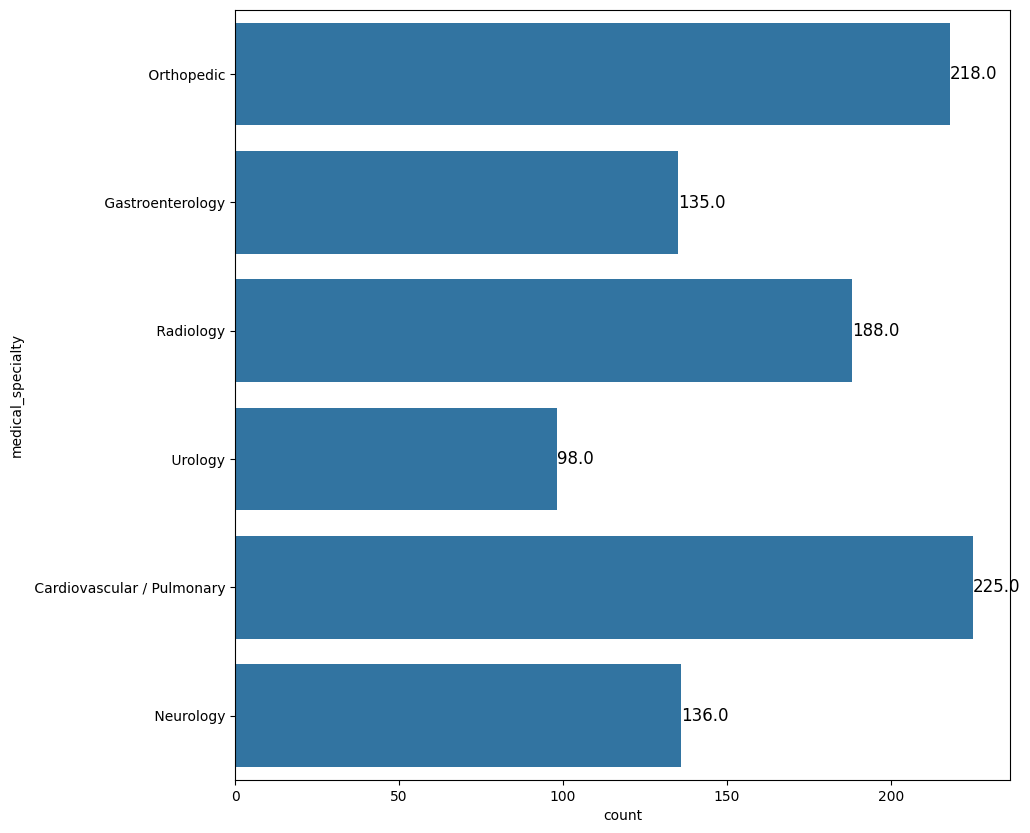

In [21]:

plt.figure(figsize=(10, 10))
ax = sns.countplot(y='medical_specialty', data=filtered_clinical_text)

# Adicionar os valores numéricos no gráfico
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width}', (width, p.get_y() + p.get_height() / 2),
                va='center', ha='left', fontsize=12, color='black')

plt.show()


##e) Apresentação do tamanho dos registros por cada classe usando um gráfico de box-plots.

<ipython-input-11-ea28aeb3524c>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='medical_specialty', y='transcription_length', data=filtered_clinical_text, palette='viridis')


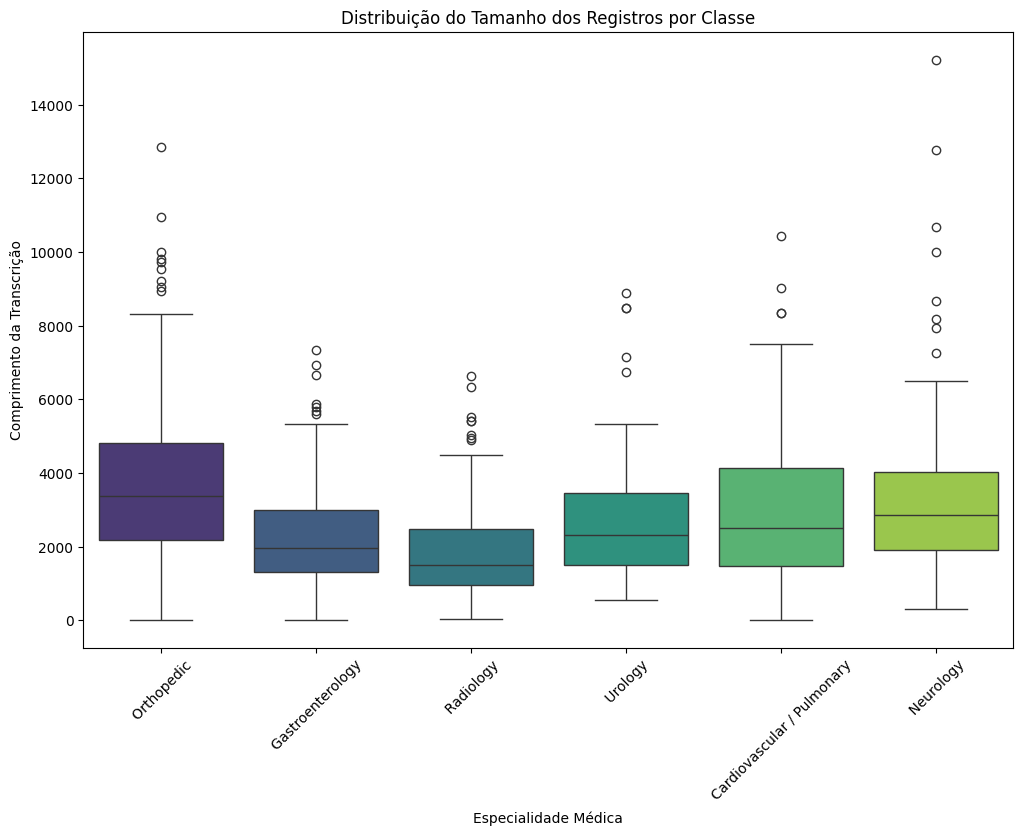

In [11]:
# Calculando o tamanho dos registros
filtered_clinical_text['transcription_length'] = filtered_clinical_text['transcription'].apply(len)

# Criando o gráfico de box-plots
plt.figure(figsize=(12, 8))
sns.boxplot(x='medical_specialty', y='transcription_length', data=filtered_clinical_text, palette='viridis')
plt.title('Distribuição do Tamanho dos Registros por Classe')
plt.xlabel('Especialidade Médica')
plt.ylabel('Comprimento da Transcrição')
plt.xticks(rotation=45)
plt.show()


##f) Utilize a classe AutoTokenizer do Transformer através do modelo pré-treinado escolhido por você para a criaçãodo tokens do dataset.

In [12]:

# Carregar o tokenizer do modelo pré-treinado
tokenizer = AutoTokenizer.from_pretrained('finiteautomata/bertweet-base-sentiment-analysis')

# Função para tokenizar o texto
def tokenize_text(text):
    return tokenizer(text, truncation=True, padding='max_length', max_length=512, return_tensors='pt')

# Aplicar tokenização ao dataset
filtered_clinical_text['tokens'] = filtered_clinical_text['transcription'].apply(tokenize_text)

# Verificar a estrutura dos tokens
print("Estrutura dos tokens:")
print(filtered_clinical_text['tokens'].head())

# Exibir exemplos de tokens
print("\nExemplos de tokens:")
for i, tokens in enumerate(filtered_clinical_text['tokens'].head()):
    print(f"\nTexto original: {filtered_clinical_text['transcription'].iloc[i]}")
    print(f"Tokens: {tokens['input_ids'].squeeze().tolist()}")
    print(f"Tokens decodificados: {tokenizer.convert_ids_to_tokens(tokens['input_ids'].squeeze().tolist())}")

# Verificar o comprimento dos tokens
print("\nComprimento dos tokens:")
filtered_clinical_text['length_of_tokens'] = filtered_clinical_text['tokens'].apply(lambda x: x['input_ids'].shape[1])
print(filtered_clinical_text[['medical_specialty', 'length_of_tokens']].head())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


Estrutura dos tokens:
2103    [input_ids, token_type_ids, attention_mask]
3587    [input_ids, token_type_ids, attention_mask]
1491    [input_ids, token_type_ids, attention_mask]
150     [input_ids, token_type_ids, attention_mask]
2361    [input_ids, token_type_ids, attention_mask]
Name: tokens, dtype: object

Exemplos de tokens:

Texto original: PREOPERATIVE DIAGNOSIS: , Left distal radius fracture, metaphyseal extraarticular.,POSTOPERATIVE DIAGNOSIS: , Left distal radius fracture, metaphyseal extraarticular.,PROCEDURE: , Open reduction and internal fixation of left distal radius.,IMPLANTS:  ,Wright Medical Micronail size 2.,ANESTHESIA: , LMA.,TOURNIQUET TIME: , 49 minutes.,BLOOD LOSS: , Minimal.,COMPLICATIONS: , None.,PATHOLOGY: , None.,TIME OUT: , Time out was performed before the procedure started.,INDICATIONS:,  The patient was a 42-year-old female who fell and sustained a displaced left metaphyseal distal radius fracture indicated for osteosynthesis.  The patient was in early stag

##g) Utilize o modelo pré-treinado escolhido por você através da classe AutoModel do Transformer para gerar os embeddings resultantes dos estados escondidos.

In [13]:
# Carregar o tokenizer e o modelo pré-treinado
tokenizer = AutoTokenizer.from_pretrained('finiteautomata/bertweet-base-sentiment-analysis')
model = AutoModel.from_pretrained('finiteautomata/bertweet-base-sentiment-analysis')

def get_hidden_states(text, model, tokenizer, max_length=128):
    inputs = tokenizer(text, return_tensors='pt', max_length=max_length, truncation=True, padding='max_length')
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    last_hidden_states = outputs.last_hidden_state
    return last_hidden_states

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at finiteautomata/bertweet-base-sentiment-analysis and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##h) Extraia e apresente os últimos estados escondidos.

In [14]:
# Exemplo de transcrição
example_text = X_train.iloc[0]  # Usando a primeira transcrição do conjunto de treinamento
example_hidden_states = get_hidden_states(example_text, model, tokenizer)

# Exibir o tamanho dos últimos estados escondidos
print(f"Shape dos últimos estados escondidos: {example_hidden_states.shape}")

Shape dos últimos estados escondidos: torch.Size([1, 128, 768])


##i) Converta todos os estados escondidos para uma estrturua tensor do PyTorch e passe-os como entrada para o modelo escolhido.

In [15]:
# Função para gerar embeddings para um conjunto de textos
def get_all_hidden_states(texts, model, tokenizer):
    embeddings = [get_hidden_states(text, model, tokenizer) for text in texts]
    return torch.cat(embeddings, dim=0)  # Concatena ao longo do eixo de batch

# Gerar embeddings para treinamento e validação
train_embeddings = get_all_hidden_states(X_train, model, tokenizer)
val_embeddings = get_all_hidden_states(X_val, model, tokenizer)

##j) Apresente a estrutura do tensor, incluindo quantos campos possui e o número de dimensões utilizados para representá-lo.

In [16]:
# Verificar a estrutura dos tensores
print(f"Formato dos embeddings de treinamento: {train_embeddings.shape}")
print(f"Formato dos embeddings de validação: {val_embeddings.shape}")

Formato dos embeddings de treinamento: torch.Size([800, 128, 768])
Formato dos embeddings de validação: torch.Size([100, 128, 768])


##k) Crie os vetores de treinamento e validação e apresente o seu formato utilizando o método shape.

Os vetores train_embeddings e val_embeddings já foram criados no passo anterior. O formato pode ser exibido com o código acima.

##l) Apresente a visualização do conjunto de treinamento utilizando o algoritmo UMAP para reduzir o número de dimensões existentes para duas dimensões. Apresente a visualização de forma similar à figura apresentada na página 43 do capítulo 2.

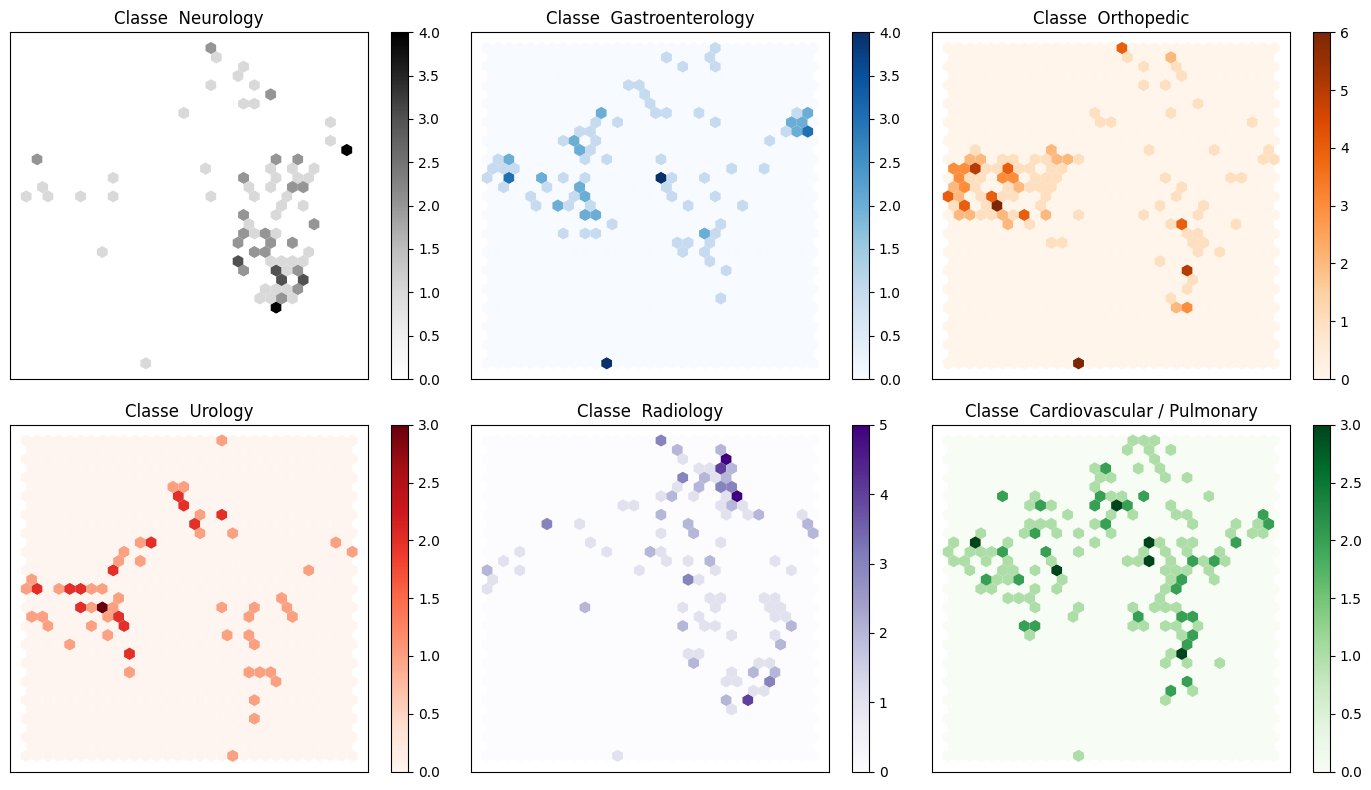

In [17]:

# Convertendo embeddings para numpy e escalando
X_train_np = train_embeddings.view(train_embeddings.size(0), -1).detach().numpy()
X_scaled = MinMaxScaler().fit_transform(X_train_np)

# Inicializar e ajustar o UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

# Criar um DataFrame com os embeddings 2D
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train.values

# Criar subplots
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

# Definir as cores e rótulos
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = df_emb["label"].unique()

# Gerar hexbin plots para cada rótulo
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb[df_emb["label"] == label]
    hexbin = axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=30, linewidths=(0,))
    axes[i].set_title(f'Classe {label}')
    axes[i].set_xticks([]), axes[i].set_yticks([])
    # Adicionar colorbar para cada subplot
    fig.colorbar(hexbin, ax=axes[i])

plt.tight_layout()
plt.show()

##m) Interprete os resultados apresentados em relação às diferenças representadas graficamente entre cada classe apresentada no diagrama.

##n) Treine os dados com um classificador simples de regressão logística e apresente o resultado de acurácia correspondente para a atividade de classificação de texto.

In [18]:

def embeddings_to_features(embeddings):
    # Supondo que embeddings seja um array de shape (n_samples, n_tokens, n_features)
    # Achatar os embeddings em vetores 1D
    return embeddings.reshape(embeddings.shape[0], -1)

# Converta embeddings para vetores 1D
X_train_features = embeddings_to_features(np.array(train_embeddings))
X_val_features = embeddings_to_features(np.array(val_embeddings))

# Inicialize e treine o classificador
clf = LogisticRegression(max_iter=1000, multi_class='ovr')
clf.fit(X_train_features, y_train)

# Faça previsões e calcule a acurácia
y_pred = clf.predict(X_val_features)
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy of Logistic Regression: {accuracy:.4f}')

Accuracy of Logistic Regression: 0.4500


##o) Compare com o resultado de acurácia do DummyClassifier.

In [19]:
# Inicialize e treine o DummyClassifier
dummy_clf = DummyClassifier(strategy='most_frequent')  # Estratégia 'most_frequent' para prever a classe mais comum
dummy_clf.fit(X_train_features, y_train)

# Faça previsões com o DummyClassifier
y_dummy_pred = dummy_clf.predict(X_val_features)

# Calcule a acurácia do DummyClassifier
dummy_accuracy = accuracy_score(y_val, y_dummy_pred)
print(f'Accuracy of DummyClassifier: {dummy_accuracy:.4f}')

lr_accuracy = accuracy_score(y_val, y_pred)  # y_pred é o resultado da previsão com o modelo de Regressão Logística
print(f'Accuracy of Logistic Regression: {lr_accuracy:.4f}')

Accuracy of DummyClassifier: 0.1900
Accuracy of Logistic Regression: 0.4500


##p) Apresente a matriz de confusão do uso da regressão logística e discuta os resultados obtidos.

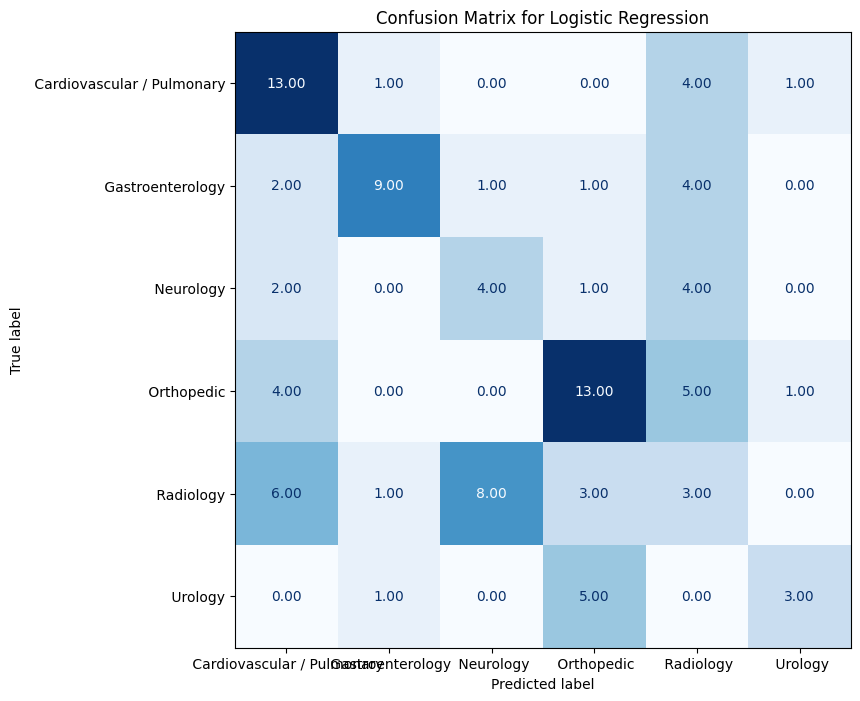

In [20]:

# Faça previsões com o classificador de Regressão Logística
y_pred = clf.predict(X_val_features)

# Calcule a matriz de confusão
cm = confusion_matrix(y_val, y_pred, labels=clf.classes_)

# Visualize a matriz de confusão
def plot_confusion_matrix(cm, labels):
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title("Confusion Matrix for Logistic Regression")
    plt.show()

# Obtenha os rótulos das classes
labels = clf.classes_

# Plote a matriz de confusão
plot_confusion_matrix(cm, labels)